# Building a Simple Recommendation System in FSharp

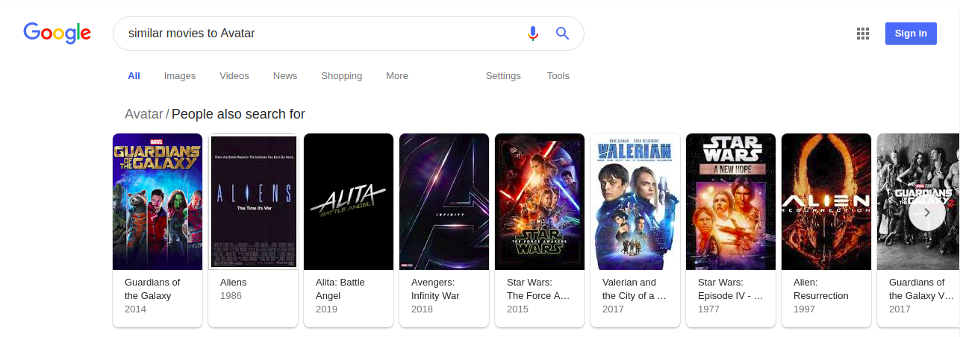

## Introduction 

This year, I decided to work on a Simple Recommender for TMDB data that can be found [here](https://www.kaggle.com/tmdb/tmdb-movie-metadata). I'd like to keep this article as simple as possible with the least amount of dependencies and ceremony. Recommendations are given on the basis of the metadata of the movie inputted based on the genres, keywords, overview, production studio and popularity score. 

This notebook is written via .NET Jupyter Notebooks whose instructions to get started can be found [here](https://github.com/dotnet/try/blob/master/NotebooksLocalExperience.md). The impetus behind writing this post was to help me and others better understand the internals of a very simple Recommendation System but also to exemplify the now improving strength of the .NET ecosystem to conduct experiments by the means of a Jupyter Notebook.

The first step involves installing all the pertinent nuget packages, which can be done in the following manner in addition to importing the relevant paths and setting the path to the csv containing all the data appropriately.

In [37]:
#r "nuget:MathNet.Numerics"
#r "nuget:MathNet.Numerics.FSharp"
#r "nuget:FSharp.Data"

// Uncomment for the IFSharp Kernel
// #load "Paket.fsx"
// Paket.Package [ "FSharp.Data"; ]
// #load "Paket.Generated.Refs.fsx"
    
open System
open System.Text
open FSharp.Data
open MathNet.Numerics
open System.Collections.Generic
open Microsoft.FSharp.Collections

[<Literal>]
// Data obtained from: https://www.kaggle.com/tmdb/tmdb-movie-metadata
let DataPath = "/Users/mukundraghavsharma/Desktop/F#/FSharp-Advent-2019/data/tmdb_5000_movies.csv"

## Data Processing

Next step is to conduct a perfunctory data exploration to view the "shape" of the columns we decide to make use of. Alternatively, I could have used [`Deedle`](https://bluemountaincapital.github.io/Deedle/) for this task.

### Data Exploration

In [12]:
let data = CsvFile.Load(DataPath).Cache()
data.Headers

Value
"[ budget, genres, homepage, id, keywords, original_language, original_title, overview, popularity, production_companies ... (10 more) ]"


Based on the headers, we will consider 2 features:
1. __Word Soup__: Consisting of sanitized words based on the genres, keywords, production companies and overview.
    - Similar movies would have similar genres, keywords, production companies and words in the overview and therefore could lead to good recommendations.
2. __Popularity__: A popularity score from TMDB.

In [13]:
let getFirstItemInColumn (colName : string) = 
    seq { for row in data.Rows -> row.GetColumn colName }
    |> Seq.head

#### Genres

In [14]:
getFirstItemInColumn "genres"

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]

#### Keywords

In [15]:
getFirstItemInColumn "keywords"

[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]

#### Overview

In [16]:
getFirstItemInColumn "overview"

In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.

#### Production Company

In [17]:
getFirstItemInColumn "production_companies"

[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]

#### Popularity

In [18]:
getFirstItemInColumn "popularity"

150.437577

Based on the samples of the columns considered, it seems like we'll need to sanitize the data extensively. Before we do so, let's define the domain objects we will be dealing with.

## Domain

In [19]:
type MovieCompareData = { title      : string; 
                          soup       : string;
                          soupList   : string list;
                          popularity : double; }

### Tokenization 

In [20]:
let tokenizeAndClean (words : string) : string list =
    // Tokenize
    let split = words.Split(' ')
    
    // Lowercase
    let lowered = 
        split
        |> Array.map(fun s -> s.ToLower())
    
    // Remove Common Stop Words that don't add meaning
    let commonStopWords = 
        Set.ofList ["ourselves"; "hers"; "between"; "yourself"; "but"; "again"; "there"; "about"; "once"; "during"; "out"; "very"; "having"; "with"; "they"; "own"; "an"; "be"; "some"; "for"; "do"; "its"; "yours"; "such"; "into"; "of"; "most"; "itself"; "other"; "off"; "is"; "s"; "am"; "or"; "who"; "as"; "from"; "him"; "each"; "the"; "themselves"; "until"; "below"; "are"; "we"; "these"; "your"; "his"; "through"; "don"; "nor"; "me"; "were"; "her"; "more"; "himself"; "this"; "down"; "should"; "our"; "their"; "while"; "above"; "both"; "up"; "to"; "ours"; "had"; "she"; "all"; "no"; "when"; "at"; "any"; "before"; "them"; "same"; "and"; "been"; "have"; "in"; "will"; "on"; "does"; "yourselves"; "then"; "that"; "because"; "what"; "over"; "why"; "so"; "can"; "did"; "not"; "now"; "under"; "he"; "you"; "herself"; "has"; "just"; "where"; "too"; "only"; "myself"; "which"; "those"; "i"; "after"; "few"; "whom"; "t"; "being"; "if"; "theirs"; "my"; "against"; "a"; "by"; "doing"; "it"; "how"; "further"; "was"; "here"; "than"]
    let notStopWords =
        lowered
        |> Array.filter(fun s -> not (Set.contains s commonStopWords))

    // Remove Punctuation
    let nonPunctation =  
        notStopWords
        |> Array.map(fun x -> x.Replace("�", "")
                               .Replace("'", "")
                               .Replace(":", "")
                               .Replace(".", "")
                               .Replace(",", "")
                               .Replace("-", "")
                               .Replace("!", "")
                               .Replace("?", "")
                               .Replace("\"", "")
                               .Replace(";", ""))
    
    // Lexicographically sort
    let sorted = Array.sort nonPunctation
    
    // Concatenate the joined data
    sorted
    |> Array.toList

In [21]:
let sample = "The quick brown. fox jumps! over the; Lazy dog" 
let tokenizedSample = tokenizeAndClean sample
tokenizedSample

index,value
0,brown
1,dog
2,fox
3,jumps
4,lazy
5,quick
6,the


### Sanitization Functions

In [22]:
// Genre
[<Literal>]
let SampleGenresJson = "[{\"id\": 28, \"name\": \"Action\"}, {\"id\": 12, \"name\": \"Adventure\"}, {\"id\": 80, \"name\": \"Crime\"}]"

type GenreProvider = JsonProvider< SampleGenresJson >

let sanitizeGenre (genres : string) : string list = 
    let parsed = GenreProvider.Parse(genres)
    parsed
    |> Array.map( fun x -> x.Name.Replace(" ", "")) 
    |> String.concat " "
    |> tokenizeAndClean

// Keywords
[<Literal>]
let SampleKeywordsJson = "[{\"id\": 1463, \"name\": \"culture clash\"}, {\"id\": 2964, \"name\": \"future\"}, {\"id\": 3386, \"name\": \"space war\"}]"

type KeywordsProvider = JsonProvider< SampleKeywordsJson >

let sanitizeKeywords (keywords : string) : string list = 
    let parsed = KeywordsProvider.Parse(keywords)
    parsed
    |> Array.map( fun x -> x.Name.Replace(" ", ""))
    |> String.concat " "
    |> tokenizeAndClean

// Overview
let sanitizeOverview (overview : string) : string list = 
    let nonAsciiRemoved = Encoding.ASCII.GetString(Encoding.ASCII.GetBytes(overview))
    tokenizeAndClean nonAsciiRemoved
    |> List.filter( fun x -> x <> String.Empty )
    
// Production Company
[<Literal>]
let ProductionCompanyJson = "[{\"name\": \"Ingenious Film Partners\", \"id\": 289}, {\"name\": \"Twentieth Century Fox Film Corporation\", \"id\": 306}, {\"name\": \"Dune Entertainment\", \"id\": 444}, {\"name\": \"Lightstorm Entertainment\", \"id\": 574}]"
type ProductionCompanyProvider = JsonProvider< ProductionCompanyJson >

let sanitizeProductionCompany (productionCompany : string) : string list = 
    let parsed = ProductionCompanyProvider.Parse(productionCompany)
    parsed
    |> Array.map( fun x -> x.Name.Replace(" ", "")) // Lightstorm Entertainment -> LightstormEntertainment
    |> String.concat " "
    |> tokenizeAndClean

## Load Data

In [23]:
let extractData =
    let data = CsvFile.Load(DataPath).Cache()
    let mutable output = []
    for row in data.Rows do
        let title    = (row.GetColumn "title")
        
        // Genres
        let genres        = sanitizeGenre (row.GetColumn "genres")
        let getSoupGenres = genres |> String.concat " "
        
        // Keywords
        let keywords       = sanitizeKeywords (row.GetColumn "keywords")
        let getSoupKeyword = keywords |> String.concat " "
        
        // Overview
        let overview        = sanitizeOverview (row.GetColumn "overview")
        let getSoupOverview = overview |> String.concat " "
        
        // Production Company
        let productionCompany        = sanitizeProductionCompany (row.GetColumn "production_companies")
        let getSoupProductionCompany = productionCompany |> String.concat " "
        
        // Soup
        let soup     = getSoupGenres + " " + getSoupKeyword + " " + getSoupOverview + " " + getSoupProductionCompany
        let soupList = genres @ keywords @ overview @ productionCompany
        
        // Popularity
        let popularity = double(row.GetColumn "popularity")
        
        // Construct data type
        let movieCompareData = { title = title; 
                                 soup  = soup;
                                 popularity = popularity;
                                 soupList = soupList }
    
        // Append the output
        output <- output @ [movieCompareData]
    output
  
let getDictOfData = 
    let out = Dictionary<string, MovieCompareData>()
    for w in extractData do
        out.[w.title] <- w
    out

In [24]:
getDictOfData
|> Seq.take 1

index,Key,Value
0,Avatar,"{ FSI_0022+MovieCompareData: title: Avatar, soup: action adventure fantasy sciencefiction 3d alien alienplanet antiwar battle cgi cultureclash future futuristic loveaffair marine mindandsoul powerrelations romance society soldier space spacecolony spacetravel spacewar tribe 22nd alien becomes century civilization dispatched following marine mission moon orders pandora paraplegic protecting torn unique duneentertainment ingeniousfilmpartners lightstormentertainment twentiethcenturyfoxfilmcorporation, soupList: [ action, adventure, fantasy, sciencefiction, 3d, alien, alienplanet, antiwar, battle, cgi ... (35 more) ], popularity: 150.437577 }"


### Word Frequency Table And Popularity Helpers

In [25]:
// Function gets all the distinct words from the soup list
let getAllWords : seq<string> = 
    extractData
    |> Seq.map(fun x -> x.soupList)
    |> Seq.concat 
    |> Seq.distinct

let getWordCountForSoup (movieCompare : MovieCompareData) = 
    let wordCount = new Dictionary<string, int>()
    for w in getAllWords do
        let count = 
            movieCompare.soupList
            |> List.filter( fun x -> x = w )
            |> List.length
        if not (wordCount.ContainsKey w) then wordCount.[w] <- count
        else wordCount.[w] <- wordCount.[w] + count
    wordCount
    
let getWordCountVectorForSoup (movieCompare : MovieCompareData) = 
    (getWordCountForSoup movieCompare).Values
    |> Seq.map (fun x -> double(x))
    |> Seq.toArray
    
let getWordCountVector (movieName : string) = 
    if getDictOfData.ContainsKey movieName then Some (getWordCountVectorForSoup getDictOfData.[movieName])
    else
        failwith "Movie Not Found!"
        
let getPopularity (movieName : string) : float[] = 
    if getDictOfData.ContainsKey movieName then ([| getDictOfData.[movieName].popularity |])
    else
        failwith "Movie Not Found!"

In [26]:
printfn "%A" (getWordCountForSoup (getDictOfData.["Avatar"]))
let avatarVector = getWordCountVector "Avatar"
printfn "%A" avatarVector
printfn "Popularity of Avatar: %A" (getPopularity "Avatar")

printfn "%A" (getWordCountForSoup (getDictOfData.["The Dark Knight Rises"]))
let darkKnightVector = getWordCountVector "The Dark Knight Rises"
printfn "%A" darkKnightVector
printfn "Popularity of The Dark Knight Rises: %A" (getPopularity "The Dark Knight Rises")

seq [[action, 1]; [adventure, 1]; [fantasy, 1]; [sciencefiction, 1]; ...]
Some
  [|1.0; 1.0; 1.0; 1.0; 1.0; 2.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 2.0;
    1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0;
    1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; ...|]
Popularity of Avatar: [|150.437577|]
seq [[action, 1]; [adventure, 0]; [fantasy, 0]; [sciencefiction, 0]; ...]
Some
  [|1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;
    0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 

## Cosine Distance

Now that we have 

In [27]:
let x : double[] = [| 3.; 1. |]
let y : double[] = [| 3.; 3. |]

printfn "Cosine Distance when values are equal: %A" (Distance.Cosine(x, x))
printfn "Cosine Distance when values are different: %A" (Distance.Cosine(x, y))

Cosine Distance when values are equal: 0.0
Cosine Distance when values are different: 0.105572809


In [28]:
let computeCosineDistance (movie1 : string) (movie2 : string) : double  = 
    let movie1Vector = getWordCountVector movie1
    let movie2Vector = getWordCountVector movie2
    
    let movie1popularity = getPopularity movie1
    let movie2popularity = getPopularity movie2
    
    match movie1Vector, movie2Vector with
    | Some m1, Some m2 -> (Distance.Cosine(m1, m2) + Distance.Cosine(movie1popularity, movie2popularity)) / 2.0
    | None, Some _ -> failwith "Movie 1 not found in the data."
    | Some _, None -> failwith "Movie 2 not found in the data."
    | _ -> failwith "Neither of the movies found in the data."

In [29]:
computeCosineDistance "Avatar" "The Dark Knight Rises"

0.48450496729866754

# Recommendations

Now that we have all the pieces, we can easily wrap up the logic into one function that takes in the movie name and number of recommendations and returns back a list of tuples comprising of the name of recommended movie and the cosine distance.

In [30]:
let recommendMovies (movie : string) (recommendationCount : int) =
    if getDictOfData.ContainsKey movie then
        let movieData = getDictOfData.[movie]
        getDictOfData
        |> Seq.filter( fun x -> not( x.Value = movieData )) // Don't include the current item in question.
        |> Seq.map( fun x -> (x.Value.title, computeCosineDistance movie x.Value.title ))
        |> Seq.filter( fun x -> not( System.Double.IsNaN( snd x )))
        |> Seq.sortBy( fun x -> snd x )
        |> Seq.take (recommendationCount)
        |> Seq.toList
    else
        failwith "Movie not found!"

In [34]:
let avatarResults = 
    (recommendMovies "Avatar" 10)
    |> List.iter( fun x -> printfn "%A" x)
avatarResults

("Titan A.E.", 0.3825721519)
("Aliens vs Predator: Requiem", 0.3923173769)
("Predators", 0.3979591837)
("Jupiter Ascending", 0.3989847455)
("Independence Day", 0.4029476828)
("Lifeforce", 0.4062296483)
("Small Soldiers", 0.410197349)
("Prometheus", 0.4107578503)
("Ender's Game", 0.4118266572)
("Predator", 0.4133801339)
